In this homework, we will look at how python can be used to analyze data using the pandas data analysis package, how we can model data using probability distributions studied in class and perform pattern recognition.

We will be using a data file that has been obtained from https://www.kaggle.com/mustafaali96/weight-height. This dataset has 10,000 rows and 3 columns nameed “Gender”, “Height” and “Weight”. Each row provides the gender, height and weight of a person. Height is given in inches and weight in pounds.

In this problem, we extract two smaller datasets from this dataset: "train_data" and "test_data". 

We will use the "train_data" dataset to visualize the joint behavior of the two random variables, height and weight, by plotting a 2D scatter plot and a contour plot of the 2D Gaussian distribution fit to this dataset. We will also visualize the conditional distributions of height and weight given gender. By analyzing the empirical distributions of the Height and Weight, we will build threshold classifiers that compares either the height or the weight to a fixed threshold to classify an entry as being either "Male" or "Female."

We will evalate the performance of the classifiers on the "test_data" dataset. We compare the classification results with the "ground truth" labels contained in the Gender column to compute the empirical classification accuracy. The reason we use a separate dataset to evaluate the performance is that this better reflects the actual performance of the classifier in the field, where it will encounter new people, not previously seen during training.

Finally, we will build a threshold classifier that acts on a linear combination of the two features (e.g., the height and the weight), and compare its performance with the classifiers based on height or weight alone. 

Download the file "weight-height.csv" from the course website to complete the homework. 

We recommend you use the pandas package, numpy package and the scipy and matplotlib.pyplot libraries in python, as you have done in previous homeworks.

For more information about pandas, please see https://pandas.pydata.org/ 

After you have completed the notebook, export it as pdf for submission. You can do this in one of two ways:
1. Go to File, click Download as, click PDF via LaTeX (.pdf).
2. Go to File, click Download as, click HTML (.html), then convert the html file to pdf file.

We first load all the packages we need for this homework.

In [1]:
# load pandas, a data analysis package
# load numpy, a scientific computing package
# load scipy.stats, a module contains probability functions
# load matplotlib.pyplot, a framework provides a Matlab-like plotting
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

In [2]:
# threshold classifier
def threshold_classifier(feature, threshold):
    # if feature value is greater than the threshlod, classify to Male. Otherwise, Female
    output = np.where(feature>=threshold, 'Male', 'Female')
    return output

In [3]:
# compare the two sets of labels
def compare_labels(testlabel, ground_truth):
    correct = np.where(testlabel==ground_truth,1, 0)
    accuracy = sum(correct)/np.size(correct)
    return accuracy

Below, we load the datafile using **pandas.read_csv** function into a **pandas.DataFrame**. We then create two subsets, "train_data" and "test_data" of size "n_train" and "n_test".  The datasets should have an equal number of males and females, so the number of data in each dataset should be even.

In [4]:
# read data
raw_data = pd.read_csv('weight-height.csv')

# sizes of smaller datasets
n_test = 800
n_train = 1600

# note the first 5000 rows of raw_data are males and the last 5000 are females.
test_data = pd.concat([ raw_data[0:(n_test//2)], raw_data[5000:(5000+n_test//2)] ])
train_data = pd.concat([ raw_data[n_test//2:(n_test//2+n_train//2)], \
                       raw_data[(5000+n_test//2) : (5000+n_test//2+n_train//2)] ])

train_data

,Gender,Height,Weight
400,Male,69.970904,202.863293
401,Male,65.313462,163.357332
402,Male,71.906005,217.027715
403,Male,66.233904,183.161232
404,Male,65.814943,166.583611
...,...,...,...
6195,Female,66.066489,158.503983
6196,Female,59.830264,99.724742
6197,Female,64.007838,135.667416
6198,Female,64.110915,134.164839


Below, we visualize the joint behavior of two random variables by plotting a 2D scatter plot of height and weight.

We plot the 2D scatter plots using ax.scatter.

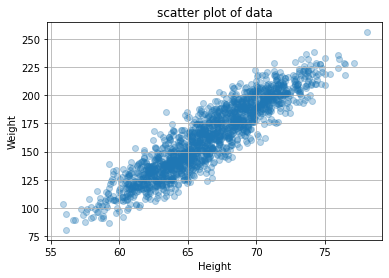

In [5]:
# create figure
fig, ax = plt.subplots()

# create scatter plot
ax.scatter(train_data['Height'], train_data['Weight'], alpha=0.3)

plt.xlabel('Height')
plt.ylabel('Weight')
plt.grid(True)
ax.set_title('scatter plot of data')

plt.show()

We start by modelling the joint distribution of height and weight using a 2D Gaussian distribution $f_{X,Y}(x,y)$ with mean vector $m$ and covariance matrix $C$, where $X$ and $Y$ are the height and weight of a person, respectively.

The code below estimates the mean and covariance that best fit the data using the **pandas.DataFrame.mean** and **pandas.DataFrame.cov** functions

In [6]:
# Compute the mean vector and covariance matrix
m = train_data[['Height','Weight']].mean()
C = train_data[['Height','Weight']].cov()
rho = train_data[['Height','Weight']].corr(method = 'pearson')

print('The mean vector of height and weight is\n')
print(m)

print('\nThe covariance matrix of height and weight is\n')
print(C)

print('\nThe correlation coefficient matrix of height and weight is\n')
print(rho)

The mean vector of height and weight is

Height     66.493410
Weight    162.367104
dtype: float64

The covariance matrix of height and weight is

            Height      Weight
Height   14.367088  109.919064
Weight  109.919064  994.581994

The correlation coefficient matrix of height and weight is

          Height    Weight
Height  1.000000  0.919535
Weight  0.919535  1.000000


The code below overlays a contour plot of the 2D Gaussian that best fits the data onto the scatterplot. 

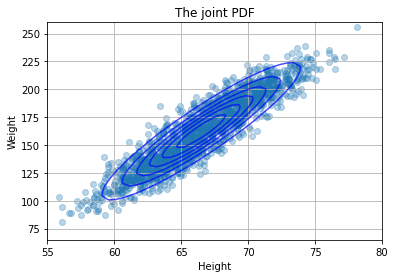

In [7]:
# create a multivariate Gaussian random variable with mean m and covariance matrix C
dist = multivariate_normal(m, C)

# create limits of plot
axlim = [55, 80, 65, 260]

# create set of (x,y) positions to compute the pdf at
x, y = np.meshgrid( np.linspace(axlim[0], axlim[1]), np.linspace(axlim[2], axlim[3]) )
pos = np.dstack((x, y))

# compute the joint Gaussian pdf
f_XY = dist.pdf(pos)

# create the plot
fig, ax = plt.subplots()

# scatter plot
ax.scatter(train_data['Height'], train_data['Weight'], alpha=0.3)

# pdf contour plot
ax.contour(x, y, f_XY, colors='b', alpha = 0.7)

# set axes and labels
ax.axis(axlim)
plt.xlabel('Height')
plt.ylabel('Weight')
plt.grid(True)
ax.set_title('The joint PDF')

plt.show()

Now, we generate the scatter plot of height and weight for each gender separately. We separate data into different groups using the **pandas.DataFrame.groupby** command.

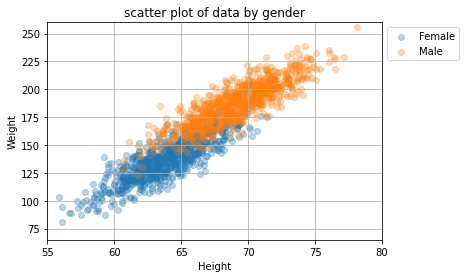

In [8]:
# create figure
fig, ax = plt.subplots()

# create one scatter plot for each gender
for name, groups in train_data.groupby('Gender'):
    ax.scatter(x='Height', y='Weight', data = groups, label = name, alpha = 0.3)

# set axes and labels
ax.axis(axlim)
ax.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
plt.xlabel('Height')
plt.ylabel('Weight')
plt.grid(True)
plt.title('scatter plot of data by gender')

plt.show()

We can see from the plot above that males are generally taller and heavier than females. 

Thus, to obtain a simple automatic classifier, we might consider applying a threshold to either the height or the weight. In other words, a person is classified as male if his/her height or weight is larger than a threshold, T, otherwise, the person is classified as a femle.

The code below uses the function **threshold_classifier** defined above to implement and test a classifier on the height. This corresponds to drawing a vertical line on the scatter plot at the threshold and classifying everything on the right as male and everything on the left as female. When we choose the threshold to be 70 inches, which is quite tall, most of the females are correctly classified, but quite a few males are classified as female. The code also shows some of the classification results for males and females. 

We use the function **compare_labels** to evaluate the performance of this classifier on the test data by comparing the output of the classifier with the ground truth labels.

The accuracy is the ratio of the correct classifications to the size of the test dataset.

You can try changing the value of the threshold, e.g. to 63, to see what happens to the errors.

Note that thresholding by weight corresponds to drawing a horizontal, rather than vertical line at the threshold. Given the shape of the scatter plot, you might be able to guess which classifier will perform better: one based on thresholding by height or one based on thresholding by weight. 

The accuracy is 0.65


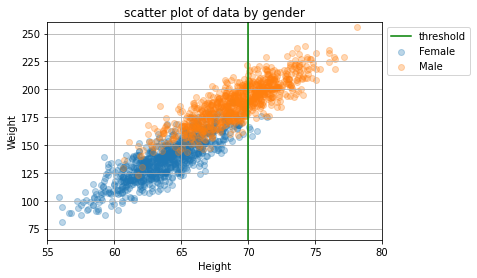

  ground_truth     height classifier output
0         Male  73.847017              Male
1         Male  68.781904            Female
2         Male  74.110105              Male
3         Male  71.730978              Male
4         Male  69.881796            Female
5         Male  67.253016            Female
6         Male  68.785081            Female
7         Male  68.348516            Female
     ground_truth     height classifier output
5392       Female  63.642045            Female
5393       Female  69.825826            Female
5394       Female  60.162510            Female
5395       Female  62.285114            Female
5396       Female  64.328491            Female
5397       Female  62.518234            Female
5398       Female  62.892831            Female
5399       Female  62.396154            Female


In [9]:
# get the ground truth labels
ground_truth = test_data['Gender'].values.tolist()

# run the threshold classifier
threshold = 70 # choose a threshold for comparison
output = threshold_classifier(test_data['Height'], threshold)

accuracy = compare_labels(output, ground_truth)
print(f'The accuracy is {accuracy}')

# create figure
fig, ax = plt.subplots()

# create one scatter plot for each gender
for name, groups in train_data.groupby('Gender'):
    ax.scatter(x='Height', y='Weight', data = groups, label = name, alpha = 0.3)
ax.plot([threshold, threshold],axlim[2:4],'g',label = 'threshold')

# set axes and labels
ax.axis(axlim)
ax.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
plt.xlabel('Height')
plt.ylabel('Weight')
plt.grid(True)
plt.title('scatter plot of data by gender')

plt.show()

d = {'ground_truth': ground_truth, 'height': test_data['Height'], 'classifier output': output}
classifier_compare = pd.DataFrame(data = d)
n_print = 8
print(classifier_compare.head(n_print))
print(classifier_compare.tail(n_print))



**Part a:** Choosing the threshold

In the code above, the threshold was chosen arbitrarily. Here, you will use probability theory to choose the threshold in a more principled manner based on data in the training set.

To do this, we note that the probability that this classifier makes an error is given by

$\mathrm{P}[\mathrm{Female\ and\ } X>T] + \mathrm{P}[\mathrm{Male \ and \ } X \leq T] $
$= \mathrm{P} [ X > T | \mathrm{Female} ] \mathrm{P} [ \mathrm{Female} ] $
$+ \mathrm{P} [ X \leq T | \mathrm{Male} ] \mathrm{P} [ \mathrm{Male} ]$


Compute the empirical conditional means and standard deviations of the height given the genders Female and Male on the training set.

Plot the probability that this classifier makes an error as a function of $T$ for 50 points ranging from 55 to 80, under the assumption that the conditional probability density functions of the height $X$ given the gender $G$, $f_{X|G}(x|g)$ and $f_{Y|G}(y|g)$ for $g \in \{ \mathrm{Female}, \mathrm{Male} \}$, are given by Gaussian distributions with the conditional means and standard deviations computed empirically from the training dataset. 

Find the optimal value of $T$ and the corresponding probability that this classifier makes an error.

the optimal value of T is:  66.73469387755102
the corresponding probability is:  0.17068029550137476


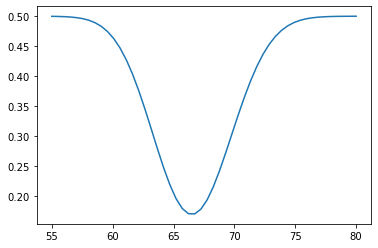

In [10]:
# put your code here
from scipy.stats import norm
t = np.linspace(55,80)
groups = train_data.groupby('Gender')['Height']
m_x_gender = groups.mean()
sd_x_gender = groups.std()
p_x_error = scipy.stats.norm.cdf(t,loc = m_x_gender['Male'], scale=sd_x_gender['Male'])*0.5 + scipy.stats.norm.sf(t,loc = m_x_gender['Female'], scale=sd_x_gender['Female'])*0.5
min_error = min(p_x_error)

fig, ax = plt.subplots()        #thes two lines are used to draw the function
ax.plot(t, p_x_error)

T = t[np.argmin(p_x_error)]
print("the optimal value of T is: ", T)
print("the corresponding probability is: ", min_error)


**Part b:** Read the data file "testdata.xlsx" and apply the threshold classifier using the threshold in **Part a**. Compute the empirical classficiation accuracy. In other word, compare the classification results with the ground truth, count the number of correct classfication and divided by the number of people, 400.

In [11]:
# put your code here
# run the threshold classifier
threshold = T # choose a threshold for comparison
output = threshold_classifier(test_data['Height'], threshold)

accuracy = compare_labels(output, ground_truth)
print(f'The accuracy is {accuracy}')


The accuracy is 0.8375


**Part c:** Repeat the steps above for a classifier based on the weight. Consider thresholds ranging from 75 to 250 pounds.

The accuracy is 0.89125


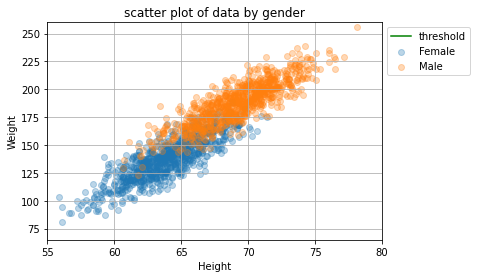

  ground_truth     height classifier output
0         Male  73.847017              Male
1         Male  68.781904              Male
2         Male  74.110105              Male
3         Male  71.730978              Male
4         Male  69.881796              Male
5         Male  67.253016              Male
6         Male  68.785081              Male
7         Male  68.348516              Male
     ground_truth     height classifier output
5392       Female  63.642045            Female
5393       Female  69.825826              Male
5394       Female  60.162510            Female
5395       Female  62.285114            Female
5396       Female  64.328491            Female
5397       Female  62.518234            Female
5398       Female  62.892831            Female
5399       Female  62.396154            Female
the optimal value of T is:  160.71428571428572
the corresponding probability is:  0.09351554771491241
The accuracy is 0.925


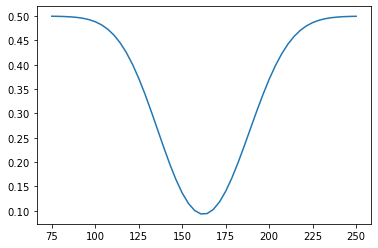

In [12]:
# put your code here
ground_truth = test_data['Gender'].values.tolist()

# run the threshold classifier
threshold = 150 # choose a threshold for comparison
output = threshold_classifier(test_data['Weight'], threshold)

accuracy = compare_labels(output, ground_truth)
print(f'The accuracy is {accuracy}')

# create figure
fig, ax = plt.subplots()

# create one scatter plot for each gender
for name, groups in train_data.groupby('Gender'):
    ax.scatter(x='Height', y='Weight', data = groups, label = name, alpha = 0.3)
ax.plot([threshold, threshold],axlim[2:4],'g',label = 'threshold')

# set axes and labels
ax.axis(axlim)
ax.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
plt.xlabel('Height')
plt.ylabel('Weight')
plt.grid(True)
plt.title('scatter plot of data by gender')

plt.show()

d = {'ground_truth': ground_truth, 'height': test_data['Height'], 'classifier output': output}
classifier_compare = pd.DataFrame(data = d)
n_print = 8
print(classifier_compare.head(n_print))
print(classifier_compare.tail(n_print))

t = np.linspace(75,250)
groups = train_data.groupby('Gender')['Weight']
m_x_gender = groups.mean()
sd_x_gender = groups.std()
p_x_error = scipy.stats.norm.cdf(t,loc = m_x_gender['Male'], scale=sd_x_gender['Male'])*0.5 + scipy.stats.norm.sf(t,loc = m_x_gender['Female'], scale=sd_x_gender['Female'])*0.5
min_error = min(p_x_error)

fig, ax = plt.subplots()        #thes two lines are used to draw the function
ax.plot(t, p_x_error)

T = t[np.argmin(p_x_error)]
print("the optimal value of T is: ", T)
print("the corresponding probability is: ", min_error)

threshold = T # choose a threshold for comparison
output = threshold_classifier(test_data['Weight'], threshold)

accuracy = compare_labels(output, ground_truth)
print(f'The accuracy is {accuracy}')


Which feature (height or weight) results in the better performing classifier?

**Your answer here:**
Using ***weight*** to measure is better.


**Part d:** Compute the mean vectors, covariance matrices and correlation coefficient matrices of height and weight for each gender.

In [13]:
# put your code here
# Compute the mean vector and covariance matrix
groups = train_data.groupby('Gender')
m_by_gender = groups.mean()
C_by_gender = groups.cov()
rho_by_gender = groups.corr(method = 'pearson')

print('The mean vector of height and weight is\n')
print(m_by_gender)

print('\nThe covariance matrix of height and weight is\n')
print(C_by_gender)

print('\nThe correlation coefficient matrix of height and weight is\n')
print(rho_by_gender)

The mean vector of height and weight is

          Height      Weight
Gender                      
Female  63.87783  137.211354
Male    69.10899  187.522854

The covariance matrix of height and weight is

                  Height      Weight
Gender                              
Female Height   6.948736   41.283264
       Weight  41.283264  347.996821
Male   Height   8.103778   46.933982
       Weight  46.933982  375.204440

The correlation coefficient matrix of height and weight is

                 Height    Weight
Gender                           
Female Height  1.000000  0.839525
       Weight  0.839525  1.000000
Male   Height  1.000000  0.851157
       Weight  0.851157  1.000000


**Part e:** Assume that the conditional joint probability density functions of height, $X$, and weight, $Y$, given the gender, $f_{X, Y|G}(x,y|g)$ for $g \in \{ \mathrm{male}, \mathrm{female} \}$, are given by Gaussian distributions with mean vectors and covariance matrices computed in **Part c**, respectively.

Overlay scatter plots of height and weight with contour diagrams of the joint densities for both genders in the same figure.

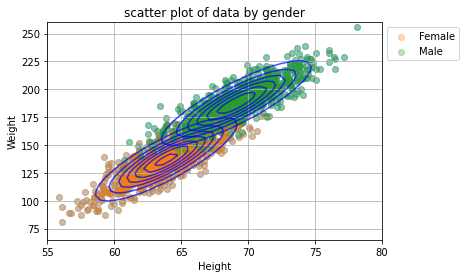

In [14]:
# put your code here
m_1 = m_by_gender.loc['Female']
C_1 = C_by_gender.loc['Female']

m_2 = m_by_gender.loc['Male']
C_2 = C_by_gender.loc['Male']

# create a multivariate Gaussian random variable with mean m and covariance matrix C
dist_1 = multivariate_normal(m_1, C_1)
dist_2 = multivariate_normal(m_2, C_2)
# create limits of plot
axlim = [55, 80, 65, 260]

# create set of (x,y) positions to compute the pdf at
x, y = np.meshgrid( np.linspace(axlim[0], axlim[1]), np.linspace(axlim[2], axlim[3]) )
pos = np.dstack((x, y))

# compute the joint Gaussian pdf
f_XY_1 = dist_1.pdf(pos)
f_XY_2 = dist_2.pdf(pos)
# create the plot
fig, ax = plt.subplots()

# scatter plot
ax.scatter(train_data['Height'], train_data['Weight'], alpha=0.3)

# pdf contour plot
ax.contour(x, y, f_XY_1, colors='b', alpha = 0.7)
ax.contour(x, y, f_XY_2, colors='b', alpha = 0.7)

# create one scatter plot for each gender
for name, groups in train_data.groupby('Gender'):
    ax.scatter(x='Height', y='Weight', data = groups, label = name, alpha = 0.3)

# set axes and labels
ax.axis(axlim)
ax.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
plt.xlabel('Height')
plt.ylabel('Weight')
plt.grid(True)
plt.title('scatter plot of data by gender')

plt.show()

**Part f:** Improving classification performance by combining features.

Intuitively, we should be able to get better classification peformance if we use more information, i.e. use both height AND weight.

One way to combine height and weight information is to linearly combine height and weight, i..e compute a new feature **D** by a weighted sum of the height and weight.

**D = w[0] * Height + w[1] * Weight**

where **w[0]** and **w[1]** are weighting coefficients.

The following code finds a good set of weighting coefficients using a technique called LDA (Linear discriminant analysis). You don't need to worry about how LDA works, just that it finds a good way to combine the features. We will use these coefficients in the following.

In [15]:
X = np.array(train_data[['Height','Weight']].values.tolist() )
y = train_data['Gender'].values.tolist()

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(X, y)
w = np.squeeze(clf.coef_)
print(f'The weighting coefficients found by LDA are w = {w}.')

The weighting coefficients found by LDA are w = [-0.42217823  0.19063352].


Compute the empirical mean and variance of D conditioned on each gender based on the mean vector and covariance matrices conditioned on gender computed above. 

In [16]:
# put your code here
M_D = np.matmul(m_by_gender,w)
C_D = C_by_gender.groupby('Gender').apply(lambda X:
np.matmul(w,np.matmul(X,w)))
print("the empirical mean of D is: " )
print(M_D)
print("the empirical variance of D is: ") 
print(C_D)

the empirical mean of D is: 
Gender
Female   -0.810746
Male      6.571830
dtype: float64
the empirical variance of D is: 
Gender
Female    7.240041
Male      7.525111
dtype: float64


**Part g:** Consider a classifier that classifies people as a male if $D$ is greater threshold $T$, and as a female otherwise. 

Plot the probability that this classifier makes an error for $T$ from -12 to 13 under the assumption that the conditional joint probability density functions of height $X$ and weight $Y$ given the gender $G$, $f_{X, Y|G}(x,y|g)$ for $c \in \{ \mathrm{Female}, \mathrm{Male} \}$, are given by Gaussian distributions with mean vectors and covariance matrices computed in **Part a**

Find the optimal vaue of $T$ and the corresponding probability that this classifier makes an error.

the optimal value of T is:  2.795918367346939
the corresponding probability is:  0.0871980122788086


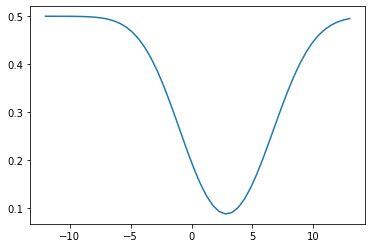

In [17]:
# put your code here
from scipy.stats import norm
t = np.linspace(-12,13)

p_x_error = scipy.stats.norm.cdf(t,loc = M_D.Male, scale=C_D.Male**(1/2))*0.5 + scipy.stats.norm.sf(t,loc = M_D.Female, scale=C_D.Female**(1/2))*0.5
min_error = min(p_x_error)

fig, ax = plt.subplots()        #thes two lines are used to draw the function
ax.plot(t, p_x_error)

T = t[np.argmin(p_x_error)]
print("the optimal value of T is: ", T)
print("the corresponding probability is: ", min_error)

**Part h:** Apply the threshold classifier using the threshold in **Part g**. Compute the empirical classficiation accuracy.

In [18]:
# run the threshold classifier
threshold = T # choose a threshold for comparison
output = threshold_classifier(w[0]*test_data['Height']+w[1]*test_data['Weight'], threshold)

accuracy = compare_labels(output, ground_truth)
print(f'The accuracy is {accuracy}')

The accuracy is 0.935


How do the test accuracies of the three threshold classifiers (based on height, weight and D) compare?

**Your answer here:**

based on **height**: the accuracy is: 0.8375

based on **weight**: the accuracy is: 0.925

based on **D**: the accuracy is: 0.935

D is better than weight and weight is better than height
